# 1. Niveles Lingüísticos

## Tarea 1: Niveles del lenguaje

### FECHA DE ENTREGA: 16 de Febrero 2025 at 11:59pm

### Fonética

1. Si tenemos un sistema de búsqueda que recibe una palabra ortográfica y devuelve sus transcripciones fonológicas, proponga una solución para los casos en que la palabra buscada no se encuentra en el lexicón/diccionario. *¿Cómo devolver o aproximar su transcripción fonológica?*
  - Reutiliza el sistema de búsqueda visto en clase y mejoralo con esta funcionalidad



In [ ]:
!pip install pyjarowinkler; pip install python-Levenshtein; pip install pykakasi; pip install opencc; pip install epitran; pip install -U sklearn-crfsuite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.9 MB/s eta 0:00:00


In [ ]:
import http
import requests as r
from pprint import pprint as pp
from rich import print as rprint
from rich.columns import Columns
from rich.panel import Panel
from rich.text import Text
from typing import Dict, Tuple
from collections import defaultdict
from typing import Callable
from pyjarowinkler import distance
from Levenshtein import distance as levenshtein_distance
import unicodedata


In [ ]:
IPA_URL = "https://raw.githubusercontent.com/open-dict-data/ipa-dict/master/data/{lang}.txt"

In [ ]:
def download_ipa_corpus(iso_lang: str) -> str:
    """Get ipa-dict file from Github

    Parameters:
    -----------
    iso_lang:
        Language as iso code

    Results:
    --------
    dict:
        Dictionary with words as keys and phonetic representation
        as values for a given lang code
    """
    print(f"Downloading {iso_lang}", end="::")
    response = r.get(IPA_URL.format(lang=iso_lang))
    status_code = response.status_code
    print(f"status={status_code}")
    if status_code != http.HTTPStatus.OK:
        print(f"ERROR on {iso_lang} :(")
        return ""
    return response.text

In [ ]:
def parse_response(response: str) -> dict:
    """Parse text response from ipa-dict to python dict

    Each row have the format:
    [WORD][TAB]/[IPA]/(, /[IPA]/)?

    Parameters
    ----------
    response: str
        ipa-dict raw text

    Returns
    -------
    dict:
        A dictionary with the word as key and the phonetic
        representations as value
    """
    ipa_list = response.rstrip().split("\n")
    result = {}
    for item in ipa_list:
        if item == '':
            continue
        item_list = item.split("\t")
        result[item_list[0]] = item_list[1]
    return result

In [ ]:
def get_ipa_transcriptions(word: str, dataset: dict) -> list[str]:
    """Search for a word in an IPA phonetics dict

    Given a word this function return the IPA transcriptions

    Parameters:
    -----------
    word: str
        A word to search in the dataset
    dataset: dict
        A dataset for a given language code

    Returns
    -------
    list[str]:
        List with posible transcriptions if any,
        else an empty list
    """
    return dataset.get(word.lower(), "").split(", ")

In [ ]:
def get_phone_symbols_freq(dataset: dict):
    """
    Calculate the frequency of each phoneme symbol from a given dataset of IPA transcriptions.

    Parameters
    ----------
    dataset : dict
        A dictionary where keys are identifiers (e.g., word IDs) and values are IPA transcriptions
        of words, represented as strings (e.g., "/kæmɹən/").

    Returns
    -------
    freqs : defaultdict
        A dictionary where keys are phoneme symbols (characters) and values are their frequencies
        of occurrence in the IPA transcriptions. Default value is 0 if the key is not present.
    """

    freqs = defaultdict(int)
    ipas = [_.strip("/") for _ in dataset.values()]
    unique_ipas = set(ipas)
    for ipa in unique_ipas:
        for char in ipa:
            freqs[char] += 1
    return freqs

In [ ]:
lang_codes = {
    "ar": "Arabic (Modern Standard)",
    "de": "German",
    "en_UK": "English (Received Pronunciation)",
    "en_US": "English (General American)",
    "eo": "Esperanto",
    "es_ES": "Spanish (Spain)",
    "es_MX": "Spanish (Mexico)",
    "fa": "Persian",
    "fi": "Finnish",
    "fr_FR": "French (France)",
    "fr_QC": "French (Québec)",
    "is": "Icelandic",
    "ja": "Japanese",
    "jam": "Jamaican Creole",
    "km": "Khmer",
    "ko": "Korean",
    "ma": "Malay (Malaysian and Indonesian)",
    "nb": "Norwegian Bokmål",
    "nl": "Dutch",
    "or": "Odia",
    "ro": "Romanian",
    "sv": "Swedish",
    "sw": "Swahili",
    "tts": "Isan",
    "vi_C": "Vietnamese (Central)",
    "vi_N": "Vietnamese (Northern)",
    "vi_S": "Vietnamese (Southern)",
    "yue": "Cantonese",
    "zh_hans": "Mandarin (Simplified)",
    "zh_hant": "Mandarin (Traditional)"
}
iso_lang_codes = list(lang_codes.keys())

In [ ]:
def get_corpora() -> dict:
    """Download corpora from ipa-dict github

    Given a list of iso lang codes download available datasets.

    Returns
    -------
    dict
        Lang codes as keys and dictionary with words-transcriptions
        as values
    """
    return {
        code: parse_response(download_ipa_corpus(code))
         for code in iso_lang_codes
        }

In [ ]:
data = get_corpora()

In [ ]:
def normalise_text(text: str) -> str:
    """
    Normalize the input text by removing accents and diacritical marks.

    This function uses Unicode normalization (NFKD) to decompose characters into their
    base characters and combining diacritical marks. Then, it removes all the combining marks
    to return the normalized version of the text.

    Parameters
    ----------
    text : str
        The input string containing text that may include accented characters or diacritical marks.

    Returns
    -------
    str
        A normalized string where characters with accents or diacritical marks have been replaced
        by their base forms (e.g., 'á' becomes 'a', 'ö' becomes 'o').

    Notes
    -----
    - The normalization uses the NFKD form, which decomposes characters into their basic
      components, and then removes the combining marks.
    """
    return ''.join(c for c in unicodedata.normalize('NFKD', text) if not unicodedata.combining(c))

In [ ]:
def levenshtein_similarity(w1: str, w2: str) -> float:
    """
    Calculate the similarity between two words using the Levenshtein distance.

    This function computes the Levenshtein distance between two strings and
    then converts it into a similarity score between 0 and 1, where 1
    indicates identical strings and 0 indicates no similarity.

    The Levenshtein distance measures the number of single-character
    edits (insertions, deletions, or substitutions) required to change
     one string into the other.

    Parameters
    ----------
    w1 : str
        The first word to compare. This word is normalized before calculating
        the similarity.

    w2 : str
        The second word to compare. This word is also normalized before
        calculating the similarity.

    Returns
    -------
    float
        A similarity score between 0 and 1. A value of 1.0 indicates the words
        are identical, and a value closer to 0 indicates less similarity.

    Notes
    -----
    - Before calculating the Levenshtein distance, the words are normalized
      to remove accents and diacritical marks using the `normalise_text`
      function.
    - The similarity score is calculated as:
      `1 - (levenshtein_distance(w1, w2) / max(len(w1), len(w2)))`.
    """
    if w1 == w2:
        return 1.0

    w1 = normalise_text(w1)
    w2 = normalise_text(w2)
    return 1 - (levenshtein_distance(w1, w2) / max(len(w1), len(w2)))

In [ ]:
SIMILARITY_METHODS: Dict[str, Callable[[str, str], float]] = {
    # --- Lenguas romances ---
    "es_MX": levenshtein_similarity,
    "es_ES": levenshtein_similarity,
    "fr_QC": levenshtein_similarity,
    "fr_FR": levenshtein_similarity,
    "it": levenshtein_similarity,
    "ro": levenshtein_similarity,
    # --- Lenguas urálicas ---
    "fi": levenshtein_similarity,
    # --- Default ---
    "default": distance.get_jaro_winkler_similarity
}

In [ ]:
def find_similar_words(word: str, dataset: dict, lang: str) -> list[tuple[str, float]]:
    """
    Find the most similar words to a given word based on a predefined similarity
    method.

    This function uses a language-specific similarity method (from
    `SIMILARITY_METHODS`) to compute similarity scores between the input word
    and the words in the provided dataset. It returns the top 7 most similar
    words.

    Parameters
    ----------
    word : str
        The word for which to find similar words. The word is converted to
        lowercase before comparison.

    dataset : dict
        A dictionary containing the dataset of words to compare against. The
        keys are the candidate words, and the values can be any associated
        information (not used in this function).

    lang : str
        The language code used to select the appropriate similarity method from
        `SIMILARITY_METHODS`.

    Returns
    -------
    list of str
        A list of the top 7 most similar words to the input word, sorted by
        similarity score in descending order.

    Notes
    -----
    - The function selects the similarity method for the given language from
      the `SIMILARITY_METHODS` dictionary.
    - If no specific method is found for the given language, the default
      method is used (`SIMILARITY_METHODS["default"]`).
    - The similarity scores are calculated by the selected method, and the
      top 7 words with the highest scores are returned.
    - The `word` and candidate words are both converted to lowercase before
      comparison to ensure case-insensitive matching.
    """
    method = SIMILARITY_METHODS.get(lang, SIMILARITY_METHODS["default"])
    word = word.lower()
    print(method)
    scores = []
    for candidate in dataset.keys():
        score = method(word, candidate.lower())
        scores.append((candidate, score))
    top = sorted(scores, key=lambda x: x[1], reverse=True)[:7]
    return [x[0] for x in top]

In [ ]:
def get_ipa_enhanced(word: str, dataset: dict, lang: str) -> list[str]:
    """
    Retrieve the IPA transcription for a given word, with enhanced search
    capabilities.

    This function first attempts to get a direct IPA transcription for the
    given word from the dataset. If no transcription is found, it searches
    for similar words based on a similarity method for the specified language.
    If no similar words are found, it falls back to a generic phonetic
    representation of the word.

    Parameters
    ----------
    word : str
        The word for which to retrieve the IPA transcription.

    dataset : dict
        A dictionary containing the dataset with words and their corresponding
        IPA transcriptions. The dataset is used for both direct lookup and
        similarity search.

    lang : str
        The language code used to select the appropriate similarity method from
        `SIMILARITY_METHODS`.

    Returns
    -------
    list of str
        A list containing the IPA transcription(s) for the input word. This
        can be a direct IPA transcription, a list of similar words' IPA
        transcriptions, or a fallback phonetic representation.

    Notes
    -----
    - The function first attempts a direct lookup in the dataset using the
      `get_ipa_transcriptions` function.
    - If no direct transcription is found, it searches for similar words
      using the `find_similar_words` function.
    - If no similar words are found, the function returns a generic fallback
      representation of the word, where each character is separated by a
      forward slash (`/`).
    """

    if ipa := get_ipa_transcriptions(word, dataset):
        if ipa[0] != "":
            return ipa

    if similars := find_similar_words(word, dataset, lang):
        return similars

    return ["/".join(list(word))]

In [ ]:
def show_title():
    """Display the title of the program or application in a formatted panel."""
    rprint(Panel(Text("Representación fonética de palabras", style="bold", justify="center")))

def show_languages():
    """
    Display a list of languages with their corresponding codes in a formatted
    panel.

    This function creates and renders a panel for each language in `lang_codes`,
    displaying the language code and name in a formatted way.
    """
    def get_formated_string(code: str, name: str):
        return f"[b]{name}[/b]\n[yellow]{code}"

    rendable_langs = [Panel(get_formated_string(code, lang), expand=True)
                     for code, lang in lang_codes.items()]
    rprint(Columns(rendable_langs))

def process_query(query: str, dataset: Dict[str, str], lang: str):
    """
    Process the query to find the IPA transcription(s) for the given word.

    This function first attempts to find a direct IPA transcription for the
    query using the `get_ipa_transcriptions` function. If no transcription is
    found, it will search for similar words and return their IPA transcriptions.
    The results are then printed in a formatted way.

    Parameters
    ----------
    query : str
        The word to query for IPA transcriptions.

    dataset : dict
        A dictionary containing words as keys and their IPA transcriptions as values.

    lang : str
        The language code used to determine the similarity method.

    Notes
    -----
    - If no direct transcription is found, it will display similar word options
      (if available).
    """
    basic = get_ipa_transcriptions(query, dataset)
    enhanced = get_ipa_enhanced(query, dataset, lang)
    result = Text()
    result.append(f"{query} → ", style="bold")
    result.append("Directo: " + ", ".join(basic) if basic[0] != "" else "No encontrado", style="green")
    if len(enhanced) > 1:
        result.append("\nOpciones similares:", style="blue")
        ipas = [get_ipa_transcriptions(x, dataset) for x in enhanced]
        for i in range(len(enhanced)):
            result.append(f"\nOpción {i+1}: ")
            result.append(f"{enhanced[i]} → ", style="bold")
            result.append(", ".join(ipas[i]) if ipas[i] != "" else "No encontrado", style="blue")
    rprint(result)

In [ ]:
show_title()
show_languages()

lang = input("lang>> ")
rprint(f"Selected language: {lang_codes[lang]}") if lang else rprint("Adios 👋🏼")

while lang:
    if lang not in lang_codes:
        rprint(f"[bold red]Error:[/bold red] Código '{lang}' inválido")
        lang = input("lang>> ")
        continue

    sub_dataset = data[lang]
    query = input(f"  [{lang}]word>> ")

    while query:
        process_query(query, sub_dataset, lang)
        query = input(f"  [{lang}]word>> ")

    lang = input("lang>> ")
    rprint(f"Selected language: {lang_codes[lang]}") if lang else rprint("Adios 👋🏼")

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                       Representación fonética de palabras                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Arabic (Modern Standard)   │ │ German                           │ │ English (Received Pronunciation) │
│ ar                         │ │ de                               │ │ en_UK                            │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ English (General American) │ │ Esperanto                        │ │ Spanish (Spain)                  │
│ en_US                      │ │ eo                               │ │ es_ES                            │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Spanish (Mexico)           │ │ Persian                          │ │ Finnish                          │
│ es_MX                      │ │ fa                               │ │ fi                               │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ French (France)            │ │ French (Québec)                  │ │ Icelandic                        │
│ fr_FR                      │ │ fr_QC                            │ │ is                               │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Japanese                   │ │ Jamaican Creole                  │ │ Khmer                            │
│ ja                         │ │ jam                              │ │ km                               │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Korean                     │ │ Malay (Malaysian and Indonesian) │ │ Norwegian Bokmål                 │
│ ko                         │ │ ma                               │ │ nb                               │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Dutch                      │ │ Odia                             │ │ Romanian                         │
│ nl                         │ │ or                               │ │ ro                               │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Swedish                    │ │ Swahili                          │ │ Isan                             │
│ sv                         │ │ sw                               │ │ tts                              │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Vietnamese (Central)       │ │ Vietnamese (Northern)            │ │ Vietnamese (Southern)            │
│ vi_C                       │ │ vi_N                             │ │ vi_S                             │
╰────────────────────────────╯ ╰──────────────────────────────────╯ ╰──────────────────────────────────╯
╭────────────────────────────╮ ╭──────────────────────────────────╮ ╭──────────────────────────────────╮
│ Cantonese                  │ │ Mandarin (Simplified)            │ │ Mandarin (Traditional)           │
│ yue     

lang>> es_MX


Selected language: Spanish (Mexico)

  [es_MX]word>> bistes
<function levenshtein_similarity at 0x794dd5885da0>


bistes → No encontrado
Opciones similares:
Opción 1: bastes → /bastes/
Opción 2: distes → /distes/
Opción 3: listes → /listes/
Opción 4: mistes → /mistes/
Opción 5: pistes → /pistes/
Opción 6: tistes → /tistes/
Opción 7: vistes → /bistes/

  [es_MX]word>> cafetera


cafetera → Directo: /kafeteɾa/

  [es_MX]word>> cafefera
<function levenshtein_similarity at 0x794dd5885da0>


cafefera → No encontrado
Opciones similares:
Opción 1: cafetera → /kafeteɾa/
Opción 2: cafeteras → /kafeteɾas/
Opción 3: cafetería → /kafeteˈɾia/
Opción 4: cabecera → /kaβeseɾa/
Opción 5: cadenera → /kaðeneɾa/
Opción 6: cafetero → /kafeteɾo/
Opción 7: calesera → /kaleseɾa/

  [es_MX]word>> 
lang>> 


Adios 👋🏼

### Morfología

2. Obtenga los datos de `test` y `dev` para todas las lenguas disponibles en el Shared Task SIGMORPHON 2022 y haga lo siguiente:
    - En un plot de 4 columnas y 2 rows muestre las siguientes distribuciones (un subplot por lengua):
        - Plot 1: distribución de longitud de palabras
        - Plot 2: distribución de la cuenta de morfemas
        - Plot 3: distribución de categorias (si existe para la lengua)
    - Realice una función que imprima por cada lengua lo siguiente:
        - Total de palabras
        - La longitud de palabra promedio
        - La cuenta de morfemas promedio
        - La categoría más común
    - Con base en esta información elabore una conclusión lingüística sobre la morfología de las lenguas analizadas.
    


In [ ]:
LANGS = {
    "ces": "Czech",
    "eng": "English",
    "fra": "French",
    "hun": "Hungarian",
    "spa": "Spanish",
    "ita": "Italian",
    "lat": "Latin",
    "rus": "Russian",
}
CATEGORIES = {
    "100": "Inflection",
    "010": "Derivation",
    "101": "Inflection, Compound",
    "000": "Root",
    "011": "Derivation, Compound",
    "110": "Inflection, Derivation",
    "001": "Compound",
    "111": "Inflection, Derivation, Compound"
}

In [ ]:
def get_track_files(lang: str, track: str = "word") -> list[str]:
    """Genera una lista de nombres de archivo del shared task

    Con base en el idioma y el track obtiene el nombre de los archivos
    para con información reelevante para hacer análisis estadístico.
    Esto es archivos .test y .dev

    Parameters:
    ----------
    lang : str
        Idioma para el cual se generarán los nombres de archivo.
    track : str, optional
        Track del shared task de donde vienen los datos (por defecto es "word").

    Returns:
    -------
    list[str]
        Una lista de nombres de archivo generados para el idioma y la pista especificados.
    """
    return [
        f"{lang}.{track}.test.gold",
        f"{lang}.{track}.dev",
    ]

In [ ]:
def get_raw_corpus(files: list) -> list:
    """Descarga y concatena los datos de los archivos tsv desde una URL base.

    Parameters:
    ----------
    files : list
        Lista de nombres de archivos (sin extensión) que se descargarán
        y concatenarán.

    Returns:
    -------
    list
        Una lista que contiene los contenidos descargados y concatenados
        de los archivos tsv.
    """
    result = []
    for file in files:
        print(f"Downloading {file}.tsv", end=" ")
        response = r.get(f"https://raw.githubusercontent.com/sigmorphon/2022SegmentationST/main/data/{file}.tsv")
        print(f"status={response.status_code}")
        lines = response.text.split("\n")
        result.extend(lines[:-1])
    return result

In [ ]:
import pandas as pd

def raw_corpus_to_dataframe(corpus_list: list, lang: str) -> pd.DataFrame:
    """Convierte una lista de datos de corpus en un DataFrame

    Parameters:
    ----------
    corpus_list : list
        Lista de líneas del corpus a convertir en DataFrame.
    lang : str
        Idioma al que pertenecen los datos del corpus.

    Returns:
    -------
    pd.DataFrame
        Un DataFrame de pandas que contiene los datos del corpus procesados.
    """
    data_list = []
    for line in corpus_list:
        try:
            word, tagged_data, category = line.split("\t")
        except ValueError:
            # Caso donde no existe la categoria
            word, tagged_data = line.split("\t")
            category = "NOT_FOUND"
        morphemes = tagged_data.split()
        data_list.append({"words": word, "morph": morphemes, "category": category, "lang": lang})
    df = pd.DataFrame(data_list)
    df["word_len"] = df["words"].apply(lambda x: len(x))
    df["morph_count"] = df["morph"].apply(lambda x: len(x))
    return df

In [ ]:
def preprocess_languages(langs):
    """
    Procesa los datos de los idiomas y los almacena en un diccionario.

    Para cada idioma en la lista de idiomas proporcionada, esta función:
    - Descarga y concatena los archivos relacionados con el idioma.
    - Convierte el corpus descargado en un DataFrame.
    - Almacena el DataFrame en el diccionario `processed_data`.

    Parameters
    ----------
    langs : list
        Lista de códigos de idiomas que se procesarán.

    Returns
    -------
    None
        La función no retorna ningún valor, solo almacena los resultados
        en el diccionario `processed_data`.
    """

    for lang in langs:
        # Obtener los archivos y procesar el corpus
        files = get_raw_corpus(get_track_files(lang))
        processed_data[lang] = raw_corpus_to_dataframe(files, lang)

In [ ]:
def plot_distribution(data, ax, title, xlabel, ylabel):
    sns.histplot(data, kde=True, ax=ax, bins=20, color='skyblue')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

In [ ]:
def print_statistics(df: pd.DataFrame, lang: str):
    """Imprime estadísticas clave para un idioma."""
    print(f'\n=== {lang.upper()} ===')
    print(f'Total palabras: {len(df)}')
    print(f'Longitud promedio: {df["word_len"].mean():.2f}')
    print(f'Morfemas promedio: {df["morph_count"].mean():.2f}')

    if "category" in df.columns:
        most_common = df["category"].mode()[0]
        print(f'Categoría más común: {CATEGORIES.get(most_common, most_common)}')

In [ ]:
processed_data = {}
preprocess_languages(LANGS)

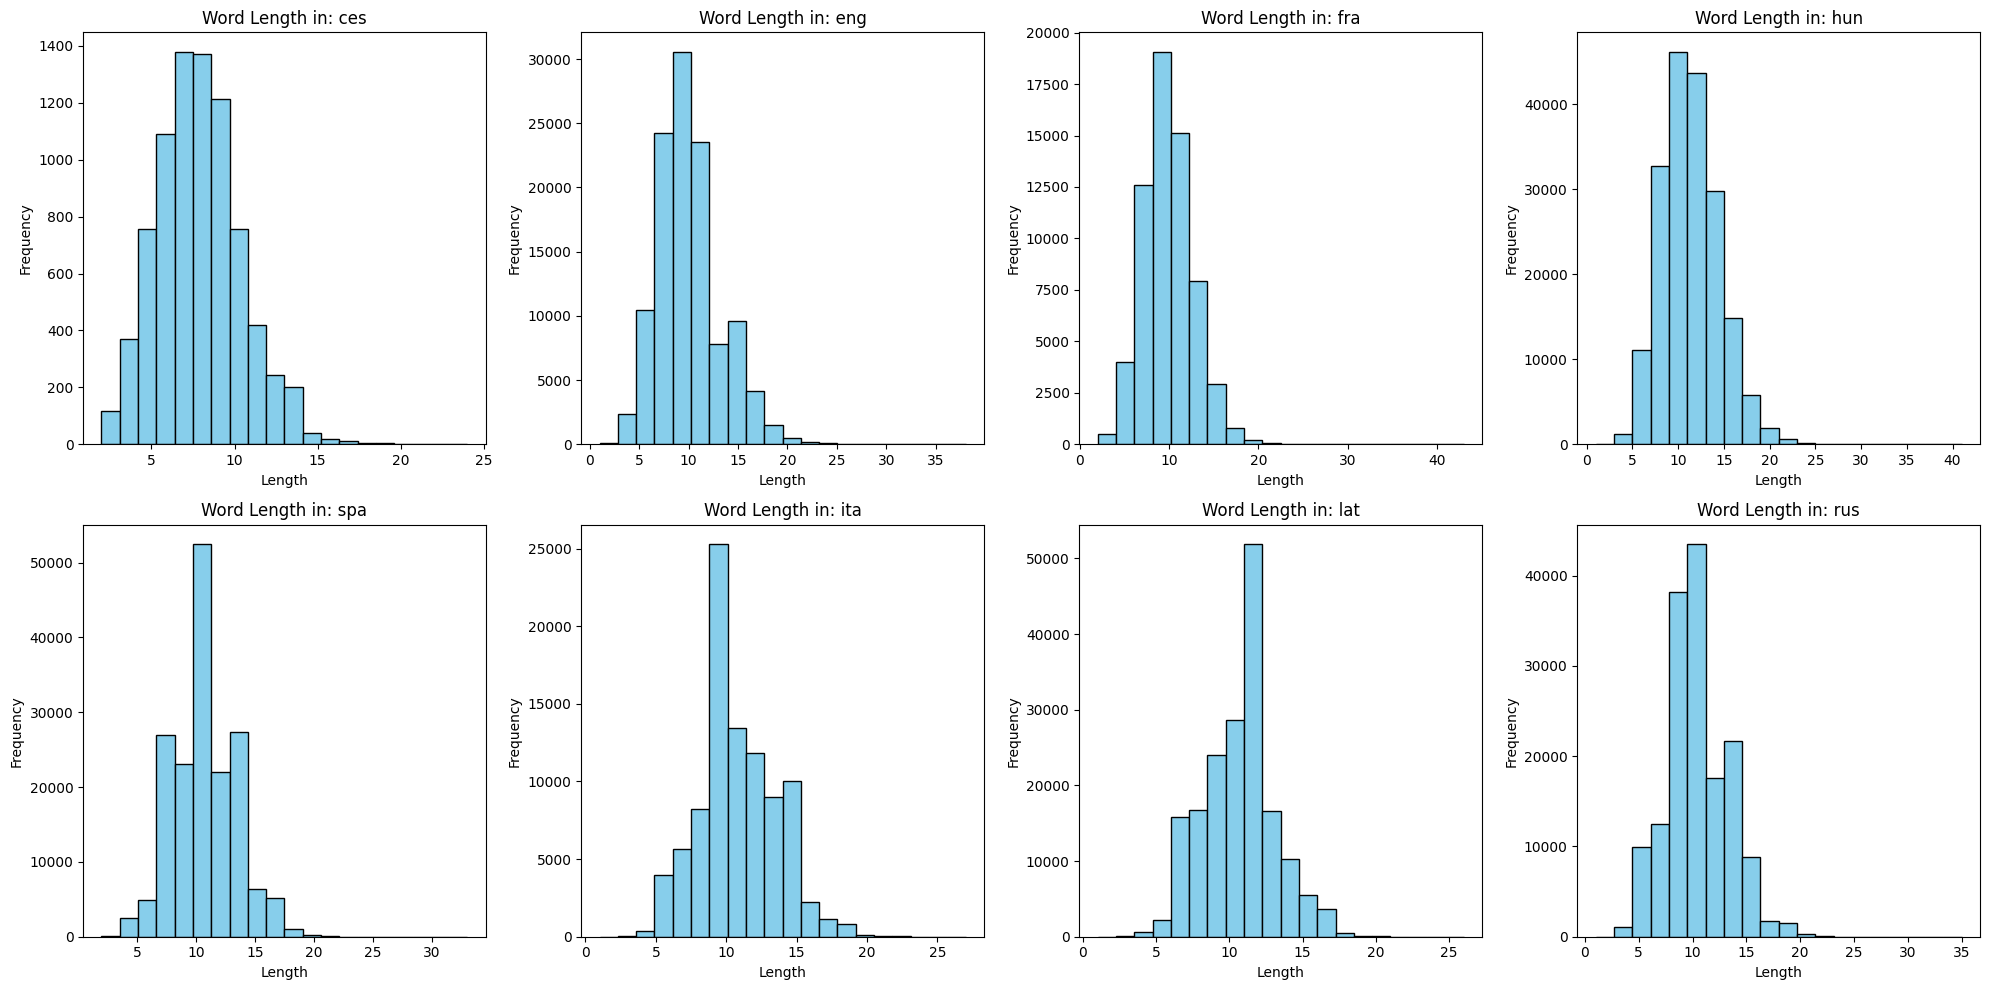

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, lang in enumerate(LANGS):
    df = processed_data[lang]

    # Subgráfico de distribución de longitud de palabras
    ax = axes[i // 4, i % 4]
    ax.hist(df["word_len"], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Word Length in: {lang}')
    ax.set_xlabel('Length')
    ax.set_ylabel('Frequency')

# Ajustar el diseño para que no se superpongan
plt.tight_layout()
plt.show()

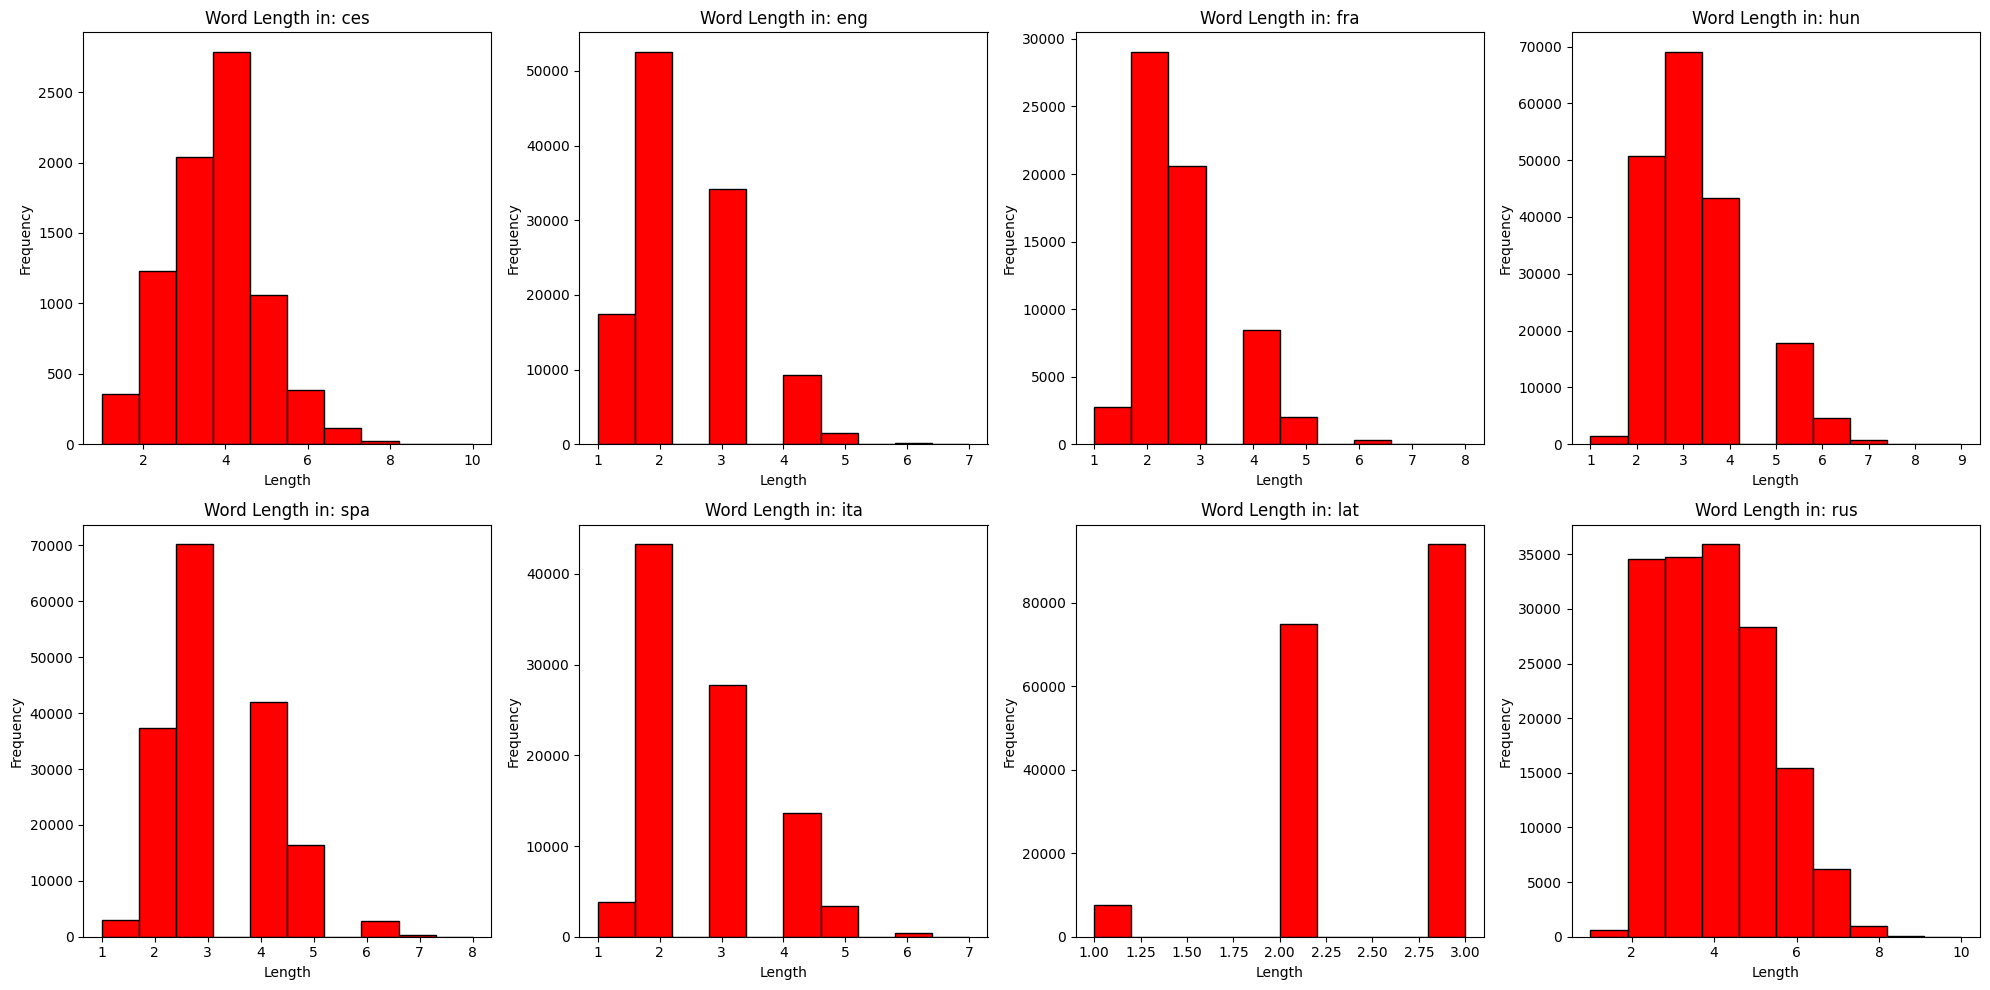

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, lang in enumerate(LANGS):
    df = processed_data[lang]

    # Subgráfico de distribución de longitud de palabras
    ax = axes[i // 4, i % 4]
    ax.hist(df["morph"].apply(len), bins=10, color='red', edgecolor='black')
    ax.set_title(f'Word Length in: {lang}')
    ax.set_xlabel('Length')
    ax.set_ylabel('Frequency')

# Ajustar el diseño para que no se superpongan
plt.tight_layout()
plt.show()

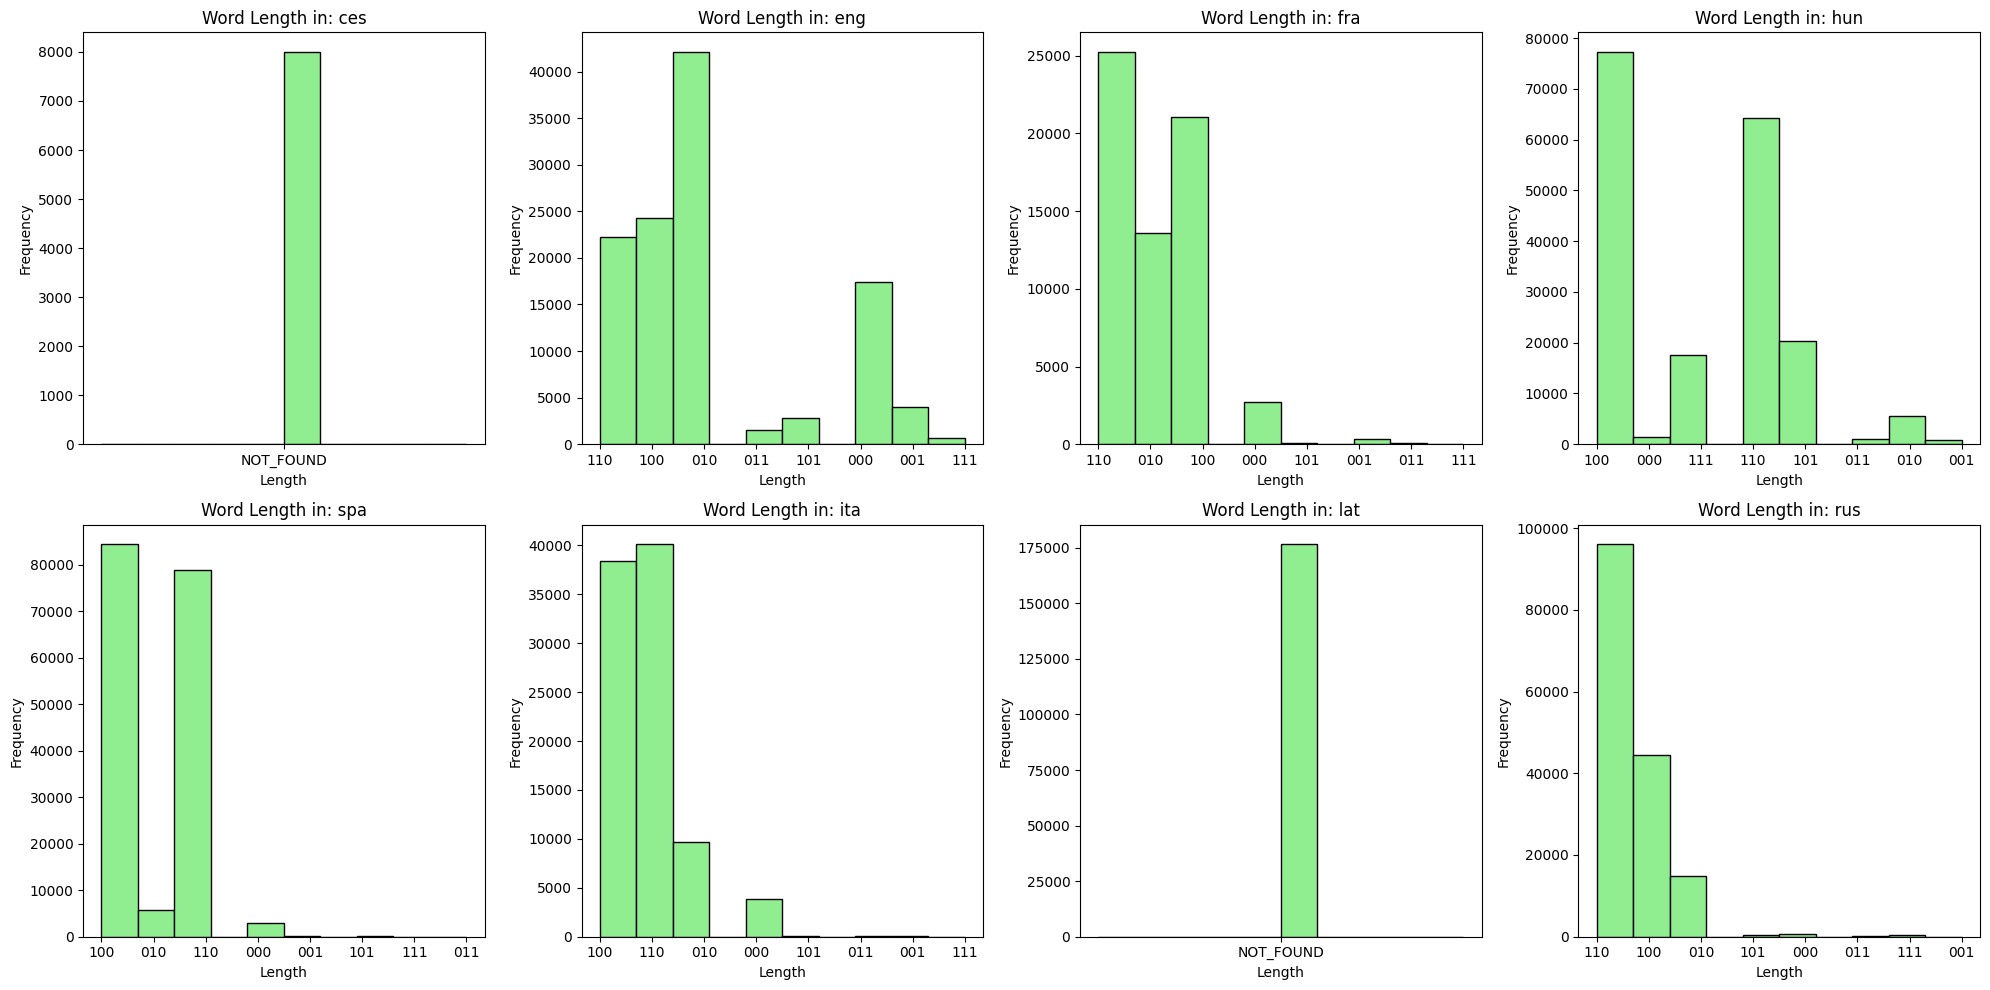

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, lang in enumerate(LANGS):
    df = processed_data[lang]

    # Subgráfico de distribución de longitud de palabras
    ax = axes[i // 4, i % 4]
    ax.hist(df["category"], bins=10, color='lightgreen', edgecolor='black')
    ax.set_title(f'Word Length in: {lang}')
    ax.set_xlabel('Length')
    ax.set_ylabel('Frequency')

# Ajustar el diseño para que no se superpongan
plt.tight_layout()
plt.show()

In [ ]:
for lang_code, lang_name in LANGS.items():
    df = processed_data[lang_code]

    # Mostrar estadísticas
    print_statistics(df, lang_name)


=== CZECH ===
Total palabras: 8000
Longitud promedio: 7.84
Morfemas promedio: 3.59
Categoría más común: NOT_FOUND

=== ENGLISH ===
Total palabras: 115126
Longitud promedio: 10.11
Morfemas promedio: 2.35
Categoría más común: Derivation

=== FRENCH ===
Total palabras: 63173
Longitud promedio: 10.20
Morfemas promedio: 2.67
Categoría más común: Inflection, Derivation

=== HUNGARIAN ===
Total palabras: 188074
Longitud promedio: 10.86
Morfemas promedio: 3.23
Categoría más común: Inflection

=== SPANISH ===
Total palabras: 172173
Longitud promedio: 10.69
Morfemas promedio: 3.24
Categoría más común: Inflection

=== ITALIAN ===
Total palabras: 92304
Longitud promedio: 10.80
Morfemas promedio: 2.68
Categoría más común: Inflection, Derivation

=== LATIN ===
Total palabras: 176467
Longitud promedio: 10.55
Morfemas promedio: 2.49
Categoría más común: NOT_FOUND

=== RUSSIAN ===
Total palabras: 156846
Longitud promedio: 10.41
Morfemas promedio: 3.85
Categoría más común: Inflection, Derivation


### Conclusión

**Longitud promedio de palabras**:
La longitud promedio de las palabras es bastante similar entre la mayoría de idiomas salvo en el checo que tiene una logitud de apenas 7 en contraste a la mayoría que están por 10.

**Promedio de morfemas por palabra**: En este caso, el número de morfemas va de 2 a 3 siendo el idioma con el mayor número promedio de morfemas por palabra es el ruso con 3.85 morfemas. Se puede notar una tendencia de que en los idiomas de Europa Central y del Este (como húngaro y ruso) presentan un mayor número promedio de morfemas, lo que podría reflejar una mayor complejidad morfológica.
   Por otro lado, El idioma con el menor promedio de morfemas es inglés con 2.35 morfemas por palabra, lo que es coherente con la naturaleza relativamente menos inflexional del inglés.

**Categoría más común**: La categoría en la mayoría de los idiomas tienen una alta prevalencia de **inflection** (flexión), lo que refleja la riqueza morfológica de esos idiomas. Aunque en algunos idiomas como español y ruso también tienen una importante presencia de derivación.

### Resumen:
Los idiomas con mayor complejidad morfológica, como ruso y húngaro, muestran un mayor número de morfemas por palabra y un uso más frecuente de inflexión y derivación. Por otro lado, inglés se distingue por tener palabras más cortas y un menor promedio de morfemas. Las categorías de palabras más comunes varían entre inflexión, derivación y combinaciones de ambas, con algunos idiomas como latín y checho mostrando una cantidad significativa de datos no categorizados.

### EXTRA:

- Imprimir la [matríz de confusión](https://en.wikipedia.org/wiki/Confusion_matrix) para el etiquetador CRFs visto en clase y elaborar una conclusión sobre los resultados

In [ ]:
import nltk

# Descargando el corpus cess_esp: https://www.nltk.org/book/ch02.html#tab-corpora
nltk.download('cess_esp')

[nltk_data] Downloading package cess_esp to /root/nltk_data...
[nltk_data]   Unzipping corpora/cess_esp.zip.


True

In [ ]:
from nltk.corpus import cess_esp
# Cargando oraciones
corpora = cess_esp.tagged_sents()

In [ ]:
import requests

def get_tags_map() -> dict:
    tags_raw = requests.get("https://gist.githubusercontent.com/vitojph/39c52c709a9aff2d1d24588aba7f8155/raw/af2d83bc4c2a7e2e6dbb01bd0a10a23a3a21a551/universal_tagset-ES.map").text.split("\n")
    tags_map = {line.split("\t")[0].lower(): line.split("\t")[1] for line in tags_raw}
    return tags_map

def map_tag(tag: str, tags_map=get_tags_map()) -> str:
    return tags_map.get(tag.lower(), "N/F")

def parse_tags(corpora: list[list[tuple]]) -> list[list[tuple]]:
    result = []
    for sentence in corpora:
        print
        result.append([(word, map_tag(tag)) for word, tag in sentence if tag not in ["Fp", "Fc", "Fpa", "Fpt"]])
    return result

corpora = parse_tags(corpora)


In [ ]:
def word_to_features(sent, i):
    word = sent[i][0]
    features = {
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'prefix_1': word[:1],
        'prefix_2': word[:2],
        'suffix_1': word[-1:],
        'suffix_2': word[-2:],
        'word_len': len(word)
    }
    if i > 0:
        prev_word = sent[i - 1][0]
        features.update({
            'prev_word.lower()': prev_word.lower(),
            'prev_word.istitle()': prev_word.istitle(),
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    return features

# Extract features and labels
def sent_to_features(sent) -> list:
    return [word_to_features(sent, i) for i in range(len(sent))]

def sent_to_labels(sent) -> list:
    return [label for token, label in sent]

In [ ]:
# Preparando datos para el CRF
X = [[word_to_features(sent, i) for i in range(len(sent))] for sent in corpora]
y = [[pos for _, pos in sent] for sent in corpora]

from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

assert len(X_train) + len(X_test) == len(corpora), "Something wrong with my split :("
assert len(y_train) + len(y_test) == len(corpora), "Something wrong with my split :("

In [ ]:
from inspect import Attribute
from sklearn_crfsuite import CRF
# Initialize and train the CRF tagger: https://sklearn-crfsuite.readthedocs.io/en/latest/api.html
crf = CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=True, verbose=True)
try:
    crf.fit(X_train, y_train)
except AttributeError as e:
    print(e)

from sklearn.metrics import classification_report
y_pred = crf.predict(X_test)

# Flatten the true and predicted labels
y_test_flat = [label for sent_labels in y_test for label in sent_labels]
y_pred_flat = [label for sent_labels in y_pred for label in sent_labels]

# Evaluate the model
report = classification_report(y_true=y_test_flat, y_pred=y_pred_flat)
print(report)


loading training data to CRFsuite: 100%|██████████| 4824/4824 [00:01<00:00, 2662.40it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 67684
Seconds required: 0.475

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.49  loss=296361.69 active=66733 feature_norm=0.50
Iter 2   time=0.16  loss=274496.22 active=66451 feature_norm=0.43
Iter 3   time=0.16  loss=268124.40 active=66864 feature_norm=0.50
Iter 4   time=0.16  loss=259997.04 active=67083 feature_norm=0.64
Iter 5   time=0.16  loss=229759.34 active=66884 feature_norm=1.46
Iter 6   time=0.16  loss=192769.26 active=67105 feature_norm=2.81
Iter 7   time=0.17  loss=162202.75 active=67202 feature_norm=4.47
Iter 8   time=0.16  loss=135392.33 active=67332 feature_norm=5.69
Iter 9   time=0.16  loss=114697.04 active=67160 feature_norm=7.82
Iter 

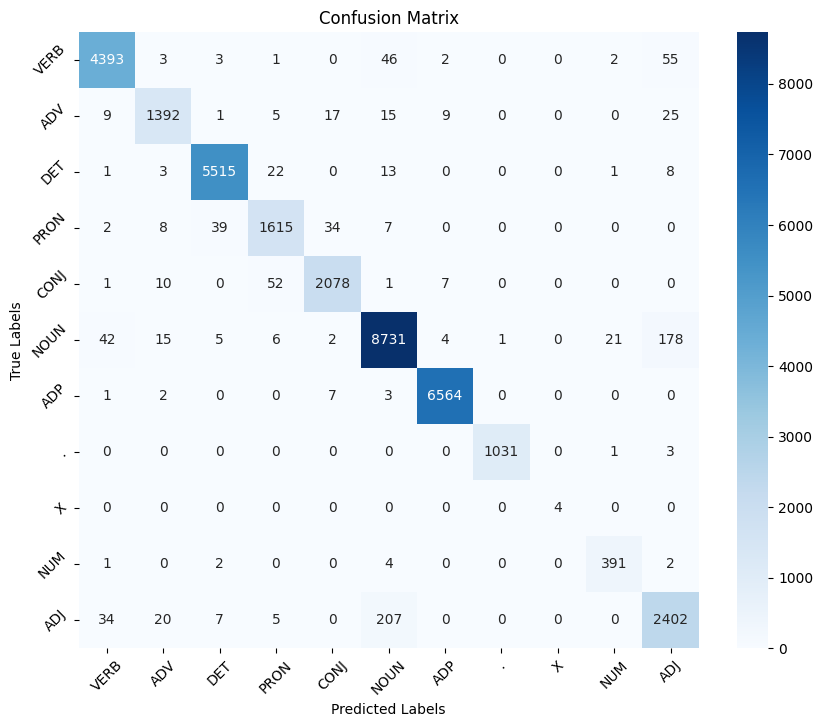

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener etiquetas únicas
labels = list(set(y_test_flat))

# Calcular matriz de confusión
conf_matrix = confusion_matrix(y_test_flat, y_pred_flat, labels=labels)

# Crear figura
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Etiquetas
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Mostrar gráfico
plt.show()
